# Imports

In [135]:
import pandas as pd
import numpy as np

import datetime as dt
import reverse_geocoder as rg
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors

from sklearn.cluster import KMeans, DBSCAN, MeanShift
import scipy.cluster.hierarchy as sch
from minisom import MiniSom



import warnings
warnings.filterwarnings("ignore")  # Suppress all warnings

from my_functions import *  #feature_engineering_info, feature_engineering_basket, all_purchased_items
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [136]:
basket_df = pd.read_csv('customer_basket.csv')
info_df = pd.read_csv('customer_info.csv')

# Exploratory Data Analysis

In [137]:
basket_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 3 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   invoice_id     100000 non-null  int64 
 1   list_of_goods  100000 non-null  object
 2   customer_id    100000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 2.3+ MB


In [138]:
basket_df.describe(include='all').T

count unique      top freq           mean             std  \
invoice_id     100000.0    NaN      NaN  NaN  6124713.66375  3533207.950417   
list_of_goods    100000  98742  ['oil']   33            NaN             NaN   
customer_id    100000.0    NaN      NaN  NaN    16945.56902     9837.987201   

                   min        25%        50%         75%         max  
invoice_id     20054.0  3066431.5  6118618.0  9195346.75  12242220.0  
list_of_goods      NaN        NaN        NaN         NaN         NaN  
customer_id        1.0     8425.0    16917.0     25536.0     34060.0

In [139]:
basket_df.head()

invoice_id                                      list_of_goods  customer_id
0     5062209  ['megaman zero 3', 'energy bar', 'pokemon viol...         4925
1     4272512  ['black beer', 'bramble', 'laptop', 'pokemon v...        19046
2     7121052  ['soup', 'shallot', 'cake', 'fresh bread', 'cr...        10318
3     5847748  ['soup', 'cooking oil', 'cereals', 'oil', 'dog...        27283
4     6336114  ['eggplant', 'mint green tea', 'oil', 'bacon',...        16072

In [140]:
info_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34060 entries, 0 to 34059
Data columns (total 26 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Unnamed: 0                               34060 non-null  int64  
 1   customer_id                              34060 non-null  int64  
 2   customer_name                            34060 non-null  object 
 3   customer_gender                          34060 non-null  object 
 4   customer_birthdate                       33719 non-null  object 
 5   kids_home                                33311 non-null  float64
 6   teens_home                               33277 non-null  float64
 7   number_complaints                        33038 non-null  float64
 8   distinct_stores_visited                  33379 non-null  float64
 9   lifetime_spend_groceries                 34060 non-null  float64
 10  lifetime_spend_electronics               34060

In [141]:
info_df.describe(include='all').T

count unique                  top  \
Unnamed: 0                               34060.0    NaN                  NaN   
customer_id                              34060.0    NaN                  NaN   
customer_name                              34060  33579         Robert Brown   
customer_gender                            34060      2                 male   
customer_birthdate                         33719  33710  12/23/1956 11:57 PM   
kids_home                                33311.0    NaN                  NaN   
teens_home                               33277.0    NaN                  NaN   
number_complaints                        33038.0    NaN                  NaN   
distinct_stores_visited                  33379.0    NaN                  NaN   
lifetime_spend_groceries                 34060.0    NaN                  NaN   
lifetime_spend_electronics               34060.0    NaN                  NaN   
typical_hour                             32698.0    NaN                  NaN   
lifetime_spend_vegetables                33038.0    NaN                  NaN   
lifetime_spend_nonalcohol_drinks         34060.0    NaN                  NaN   
lifetime_spend_alcohol_drinks            33379.0    NaN                  NaN   
lifetime_spend_meat                      34060.0    NaN                  NaN   
lifetime_spend_fish                      32357.0    NaN                  NaN   
lifetime_spend_hygiene                   34060.0    NaN                  NaN   
lifetime_spend_videogames                34060.0    NaN                  NaN   
lifetime_spend_petfood                   34060.0    NaN                  NaN   
lifetime_total_distinct_products         34060.0    NaN                  NaN   
percentage_of_products_bought_promotion  34060.0    NaN                  NaN   
year_first_transaction                   34060.0    NaN                  NaN   
loyalty_card_number                      23152.0    NaN                  NaN   
latitude                                 34060.0    NaN                  NaN   
longitude                                34060.0    NaN                  NaN   

                                          freq           mean           std  \
Unnamed: 0                                 NaN        17029.5   9832.419421   
customer_id                                NaN   20010.854433  11557.889072   
customer_name                                6            NaN           NaN   
customer_gender                          17133            NaN           NaN   
customer_birthdate                           2            NaN           NaN   
kids_home                                  NaN       1.170244      1.307319   
teens_home                                 NaN       0.936292      0.759579   
number_complaints                          NaN       0.832042      0.771205   
distinct_stores_visited                    NaN       2.914078      1.549081   
lifetime_spend_groceries                   NaN   22818.404698  20098.763199   
lifetime_spend_electronics                 NaN    3816.022343    3858.35264   
typical_hour                               NaN      13.200746      4.681384   
lifetime_spend_vegetables                  NaN     738.642079    679.599323   
lifetime_spend_nonalcohol_drinks           NaN     478.382854    282.132536   
lifetime_spend_alcohol_drinks              NaN     838.482998    596.518224   
lifetime_spend_meat                        NaN     916.211274    534.330738   
lifetime_spend_fish                        NaN     828.842662      655.8033   
lifetime_spend_hygiene                     NaN     711.297534    481.230522   
lifetime_spend_videogames                  NaN     399.434968     320.22165   
lifetime_spend_petfood                     NaN     317.755843    150.513835   
lifetime_total_distinct_products           NaN     156.691339    118.969652   
percentage_of_products_bought_promotion    NaN       0.337093      0.322766   
year_first_transaction                     NaN    2014.593218    

In [142]:
# Percentage of missing values in each column
for col in info_df.columns:
    pct_missing = np.mean(info_df[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))

Unnamed: 0 - 0%
customer_id - 0%
customer_name - 0%
customer_gender - 0%
customer_birthdate - 1%
kids_home - 2%
teens_home - 2%
number_complaints - 3%
distinct_stores_visited - 2%
lifetime_spend_groceries - 0%
lifetime_spend_electronics - 0%
typical_hour - 4%
lifetime_spend_vegetables - 3%
lifetime_spend_nonalcohol_drinks - 0%
lifetime_spend_alcohol_drinks - 2%
lifetime_spend_meat - 0%
lifetime_spend_fish - 5%
lifetime_spend_hygiene - 0%
lifetime_spend_videogames - 0%
lifetime_spend_petfood - 0%
lifetime_total_distinct_products - 0%
percentage_of_products_bought_promotion - 0%
year_first_transaction - 0%
loyalty_card_number - 32%
latitude - 0%
longitude - 0%


In [143]:
# Percentage of missing values in each column
for col in basket_df.columns:
    pct_missing = np.mean(basket_df[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))

invoice_id - 0%
list_of_goods - 0%
customer_id - 0%


# Preprocessing

In [144]:
# Get all new features for info_df
feature_engineering_info(info_df)

In [145]:
# Get all new features for basket_df
feature_engineering_basket(basket_df)

In [146]:
# Get a full list of all items purchased for each customer (with repetitions)
all_items = all_purchased_items(basket_df)

In [147]:
all_items.head()

customer_id                                all_purchased_items
0            1  [pickles, protein bar, mashed potato, beer, tu...
1            2  [shampoo, tooth brush, portal, vegetables mix,...
2            4  [shallot, mashed potato, olive oil, asparagus,...
3            5  [candy bars, zucchini, mint green tea, strong ...
4            6  [candy bars, gadget for tiktok streaming, port...

# Visualization

## General data visualization

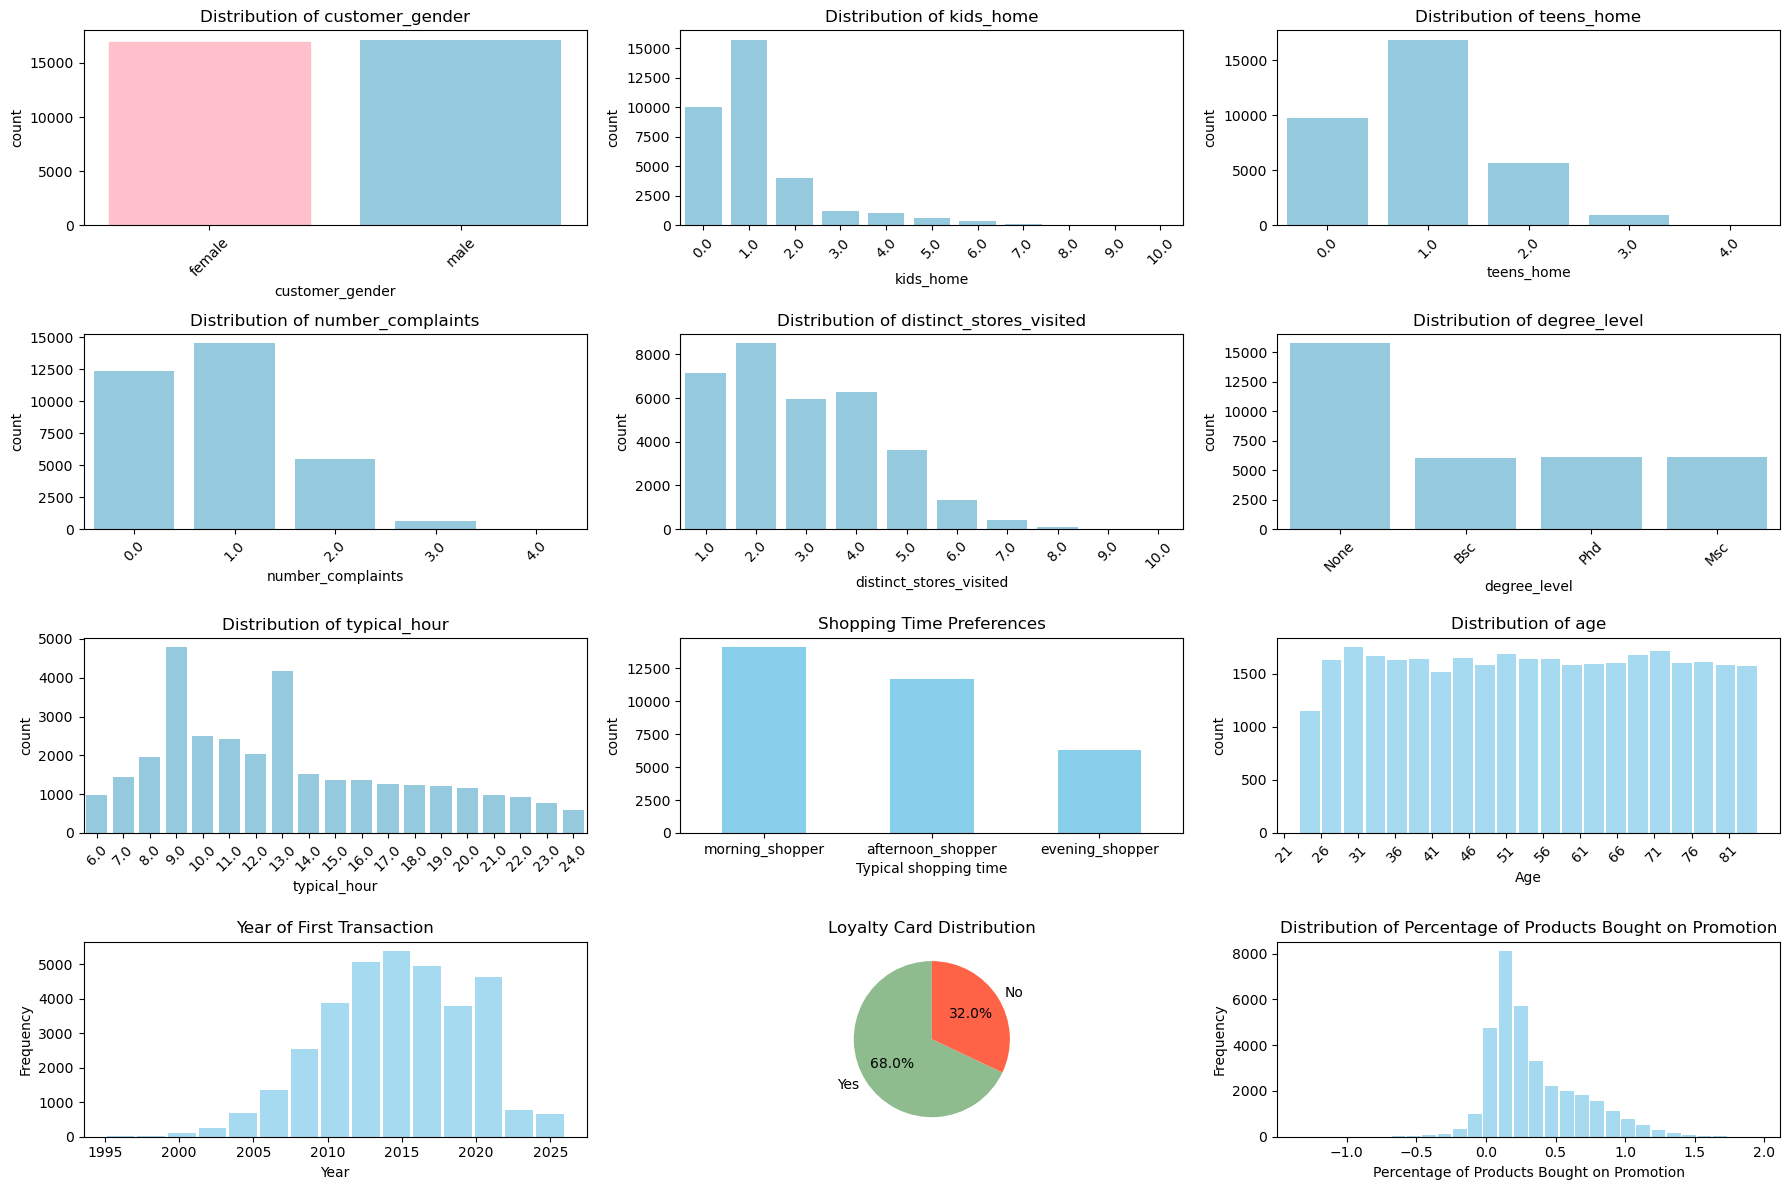

In [148]:
# Define the columns to plot
columns = ['customer_gender', 'kids_home', 'teens_home', 'number_complaints', 
           'distinct_stores_visited', 'degree_level', 'typical_hour'] 

# Create a grid of subplots
fig, axes = plt.subplots(4, 3, figsize=(18, 12))  # Adjust figure size
axes = axes.flatten()  # Flatten the axes array for easy iteration

# Plot general bar plots for each column in the list
for i, col in enumerate(columns):
    sns.countplot(data=info_df, x=col, ax=axes[i], color='skyblue')
    axes[i].set_title(f'Distribution of {col}')
    axes[i].tick_params(axis='x', rotation=45)

# Make female bar of ax 0 to be pink
bars = axes[0].patches  
bars[0].set_color('pink')


# Plot time preferences separately
time_columns = ['morning_shopper', 'afternoon_shopper', 'evening_shopper']
time_preferences = info_df[time_columns].sum()
time_preferences.plot(kind='bar', ax=axes[7], color='skyblue')
axes[7].set_title('Shopping Time Preferences')
axes[7].set_xlabel('Typical shopping time')
axes[7].set_ylabel('count')
axes[7].tick_params(axis='x', rotation=0)

# Plot ages with bins 
sns.histplot(data=info_df, x='age', ax=axes[8], binwidth=3, stat='count', linewidth=0, color='skyblue', element='bars', shrink=0.9)
axes[8].set_title(f'Distribution of age')
axes[8].set_xlabel('Age')
axes[8].set_ylabel('count')
axes[8].tick_params(axis='x', rotation=45)
axes[8].set_xticks(range(21, 86, 5))    # Add x ticks every 5 years

# Plot year of first transaction
sns.histplot(data=info_df, x='year_first_transaction', ax=axes[9], bins=15, kde=False, color='skyblue', linewidth=0, shrink=0.9)
axes[9].set_title('Year of First Transaction')
axes[9].set_xlabel('Year')
axes[9].set_ylabel('Frequency')
axes[9].tick_params(axis='x', rotation=0)

# Plot the pie chart of loyalty card distribution with a frame
loyalty_counts = info_df['loyalty_card'].map({1: 'Yes', 0: 'No'}).value_counts()
loyalty_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90, ax=axes[10], colors=['darkseagreen', 'tomato'])
axes[10].set_title('Loyalty Card Distribution')
axes[10].set_ylabel('')

# We have space for one more subplot if we need it  
# fig.delaxes(axes[11])  # Remove the empty subplot

sns.histplot(data=info_df, x='percentage_of_products_bought_promotion', ax=axes[11], color='skyblue', bins=30, linewidth=0, shrink=0.9)
axes[11].set_title('Distribution of Percentage of Products Bought on Promotion')
axes[11].set_xlabel('Percentage of Products Bought on Promotion')
axes[11].set_ylabel('Frequency')


# Adjust layout
plt.tight_layout()
plt.show()

## Customer spending visualization

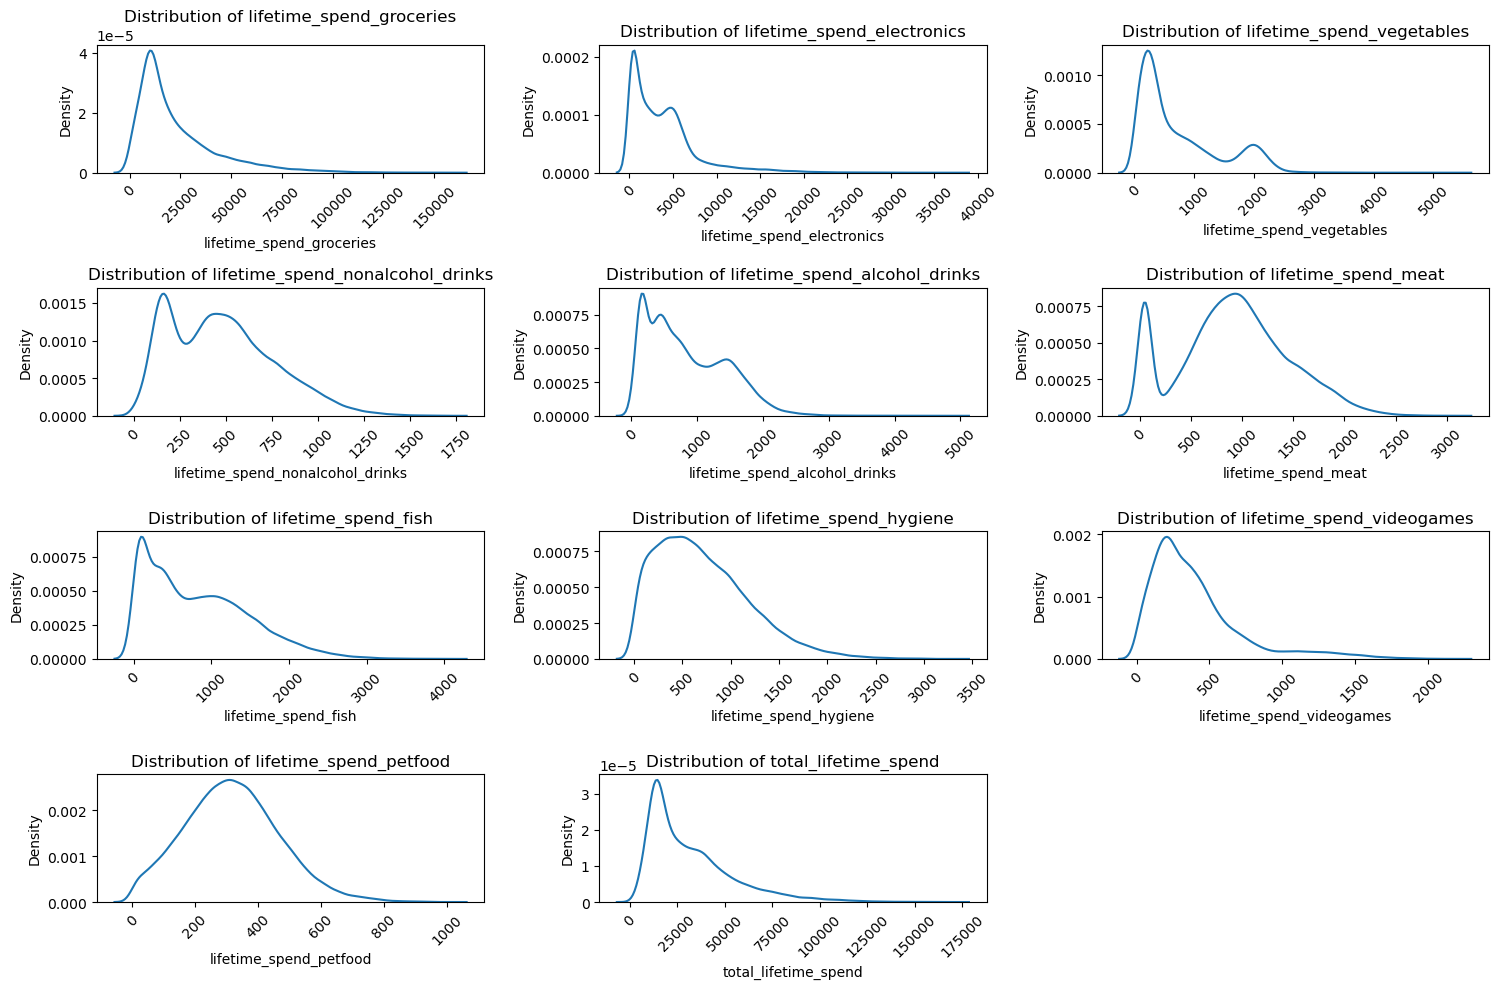

In [149]:
# Get columns with lifetime spend data
spend_columns = [col for col in info_df.columns if 'lifetime_spend' in col]  

# Create a grid of subplots
n_cols = 3  # Set the number of columns in the grid
n_rows = (len(spend_columns) + n_cols - 1) // n_cols  # Calculate the number of rows
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 10))  
axes = axes.flatten() 

# Plot each column in a subplot
for i, col in enumerate(spend_columns):
    sns.kdeplot(data=info_df, x=col, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')
    axes[i].tick_params(axis='x', rotation=45)

# Remove any unused subplots
for j in range(len(spend_columns), len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.show()

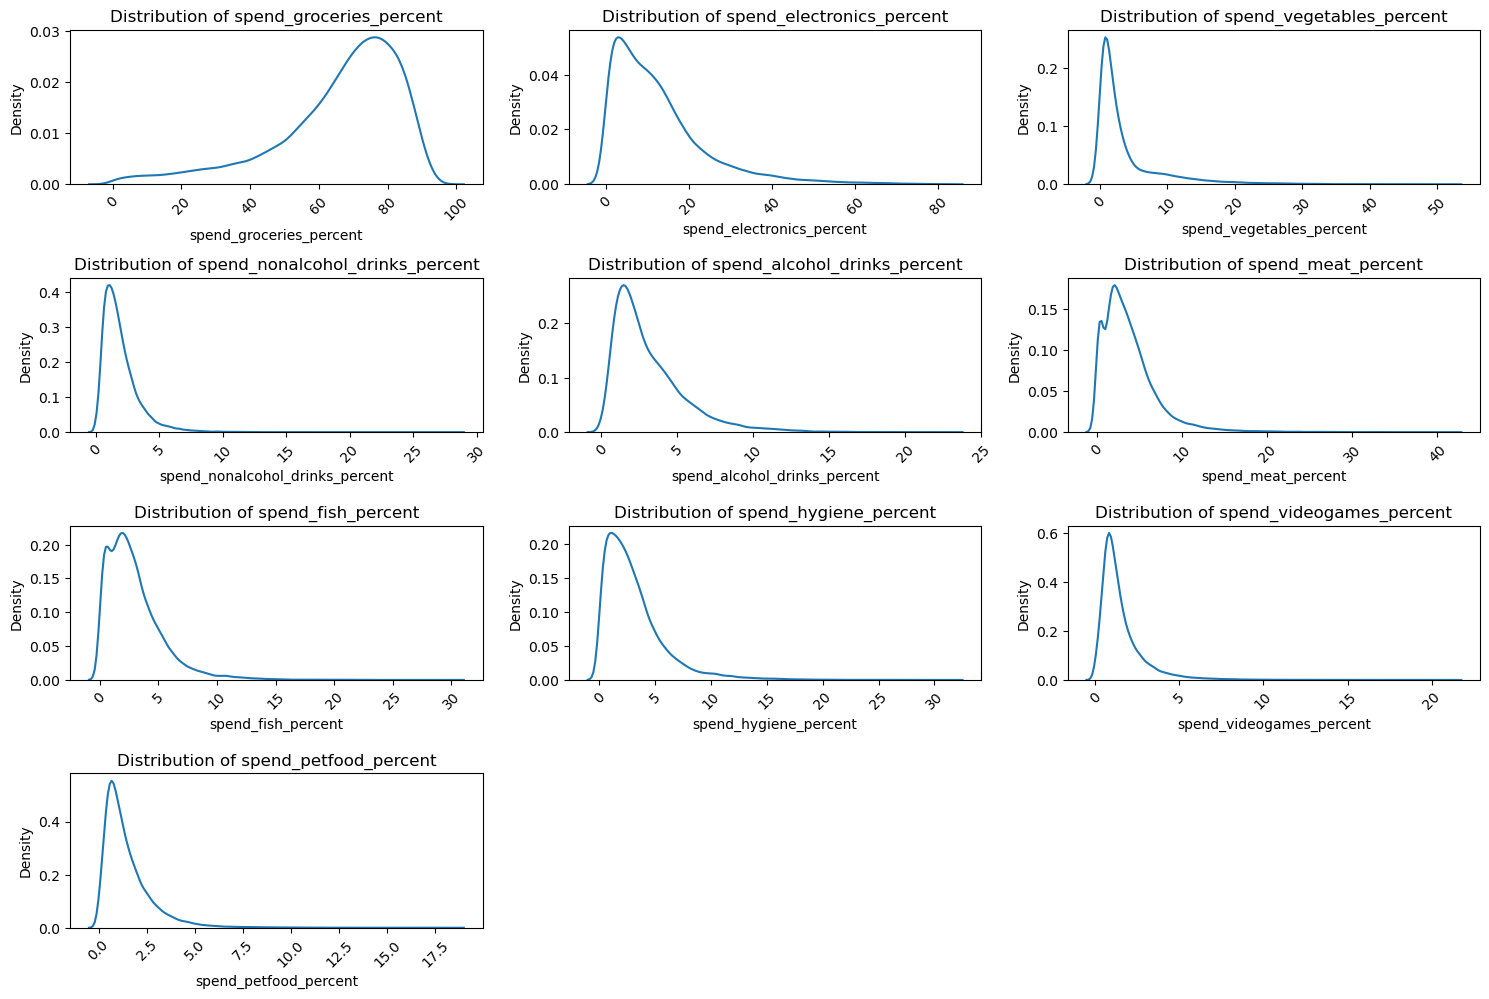

In [150]:
# Get columns with percent spend data for each category
spend_columns = [col for col in info_df.columns if '_percent' in col]

# Create a grid of subplots
n_cols = 3  # Set the number of columns in the grid
n_rows = (len(spend_columns) + n_cols - 1) // n_cols  # Calculate the number of rows
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 10))  
axes = axes.flatten()  

# Plot each column in a subplot
for i, col in enumerate(spend_columns):
    sns.kdeplot(data=info_df, x=col, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')
    axes[i].tick_params(axis='x', rotation=45)

# Remove any unused subplots
for j in range(len(spend_columns), len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.show()

## By City visualization

In [151]:
fig = px.scatter_mapbox(
    info_df,
    lat='latitude',
    lon='longitude',
    hover_name='customer_name',  # Displays customer_name on hover
    zoom=11,
    height=600,
    width=800
)

# Remove margins and white background
fig.update_layout(
    mapbox_style="open-street-map",
    margin=dict(l=0, r=0, t=0, b=0),  # Removes all margins
    paper_bgcolor='rgba(0,0,0,0)',     # Transparent background
    plot_bgcolor='rgba(0,0,0,0)'       # Transparent plot area
)

fig.show()  # Displays in notebook or browser

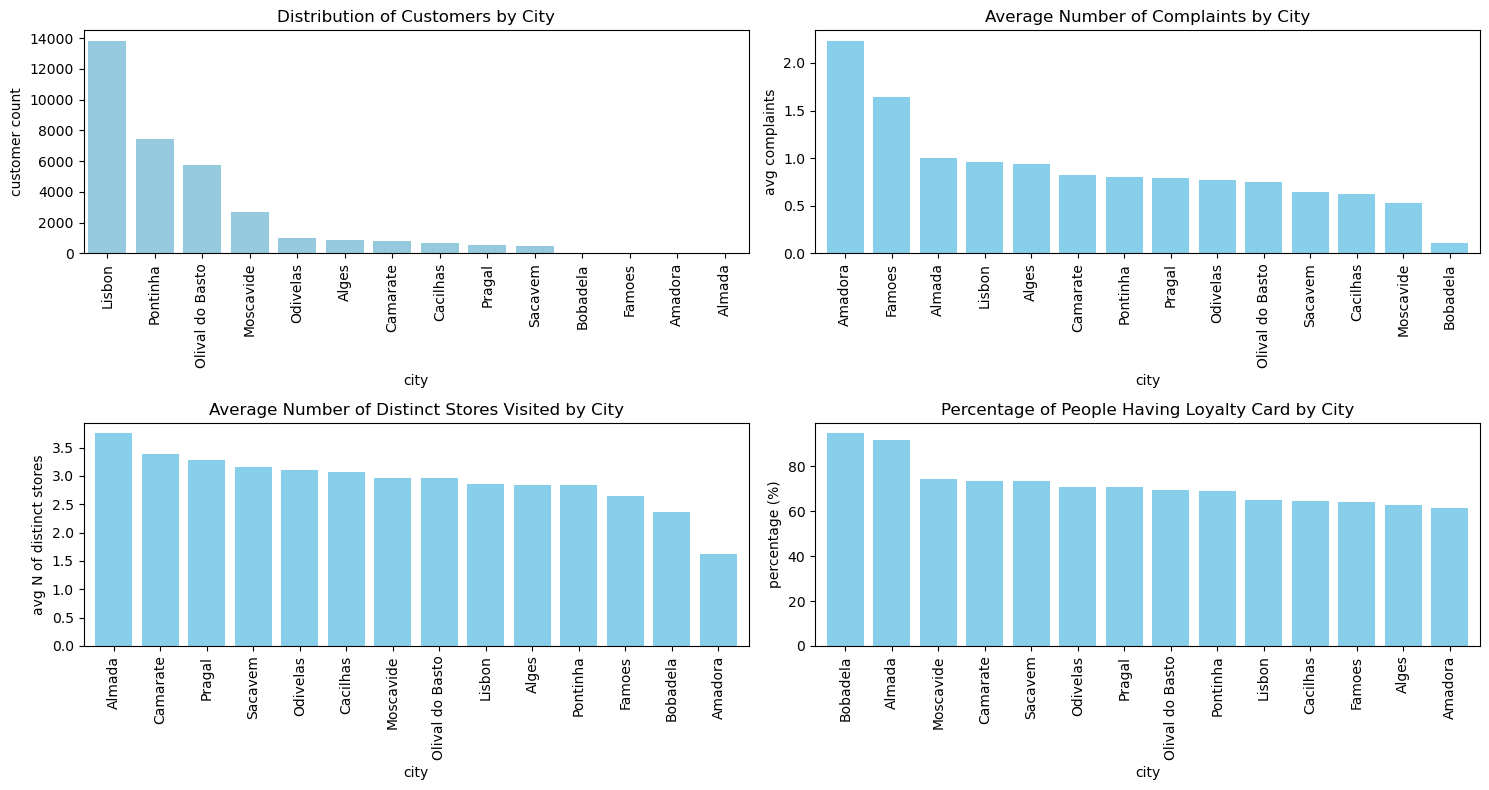

In [152]:
# Create a grid of subplots for the city analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 8))  
axes = axes.flatten()  

# Plot each subplot for the city analysis

# Distribution of Customers by City
sns.countplot(data=info_df, x='city', ax=axes[0], color='skyblue', order=info_df['city'].value_counts().index, width=0.8)
axes[0].set_title('Distribution of Customers by City')
axes[0].set_xlabel('city')
axes[0].set_ylabel('customer count')
axes[0].tick_params(axis='x', rotation=90)

# Average Number of Complaints by City
info_df.groupby('city')['number_complaints'].mean().sort_values(ascending=False).plot(kind='bar', ax=axes[1], color='skyblue', width=0.8)
axes[1].set_title('Average Number of Complaints by City')
axes[1].set_xlabel('city')
axes[1].set_ylabel('avg complaints')
axes[1].tick_params(axis='x', rotation=90)

# 'Average Number of Distinct Stores Visited by City
distinct_stores_by_city = info_df.groupby('city')['distinct_stores_visited'].mean().sort_values(ascending=False)
distinct_stores_by_city.plot(kind='bar', ax=axes[2], color='skyblue', width=0.8)
axes[2].set_title('Average Number of Distinct Stores Visited by City')
axes[2].set_xlabel('city')
axes[2].set_ylabel('avg N of distinct stores')
axes[2].tick_params(axis='x', rotation=90)

# Percentage of People Having Loyalty Card by City
loyalty_percentage_by_city = info_df.groupby('city')['loyalty_card'].mean() * 100
loyalty_percentage_by_city.sort_values(ascending=False).plot(kind='bar', ax=axes[3], color='skyblue', width=0.8)
axes[3].set_title('Percentage of People Having Loyalty Card by City')
axes[3].set_xlabel('city')
axes[3].set_ylabel('percentage (%)')
axes[3].tick_params(axis='x', rotation=90)


# Adjust layout
plt.tight_layout()
plt.show()

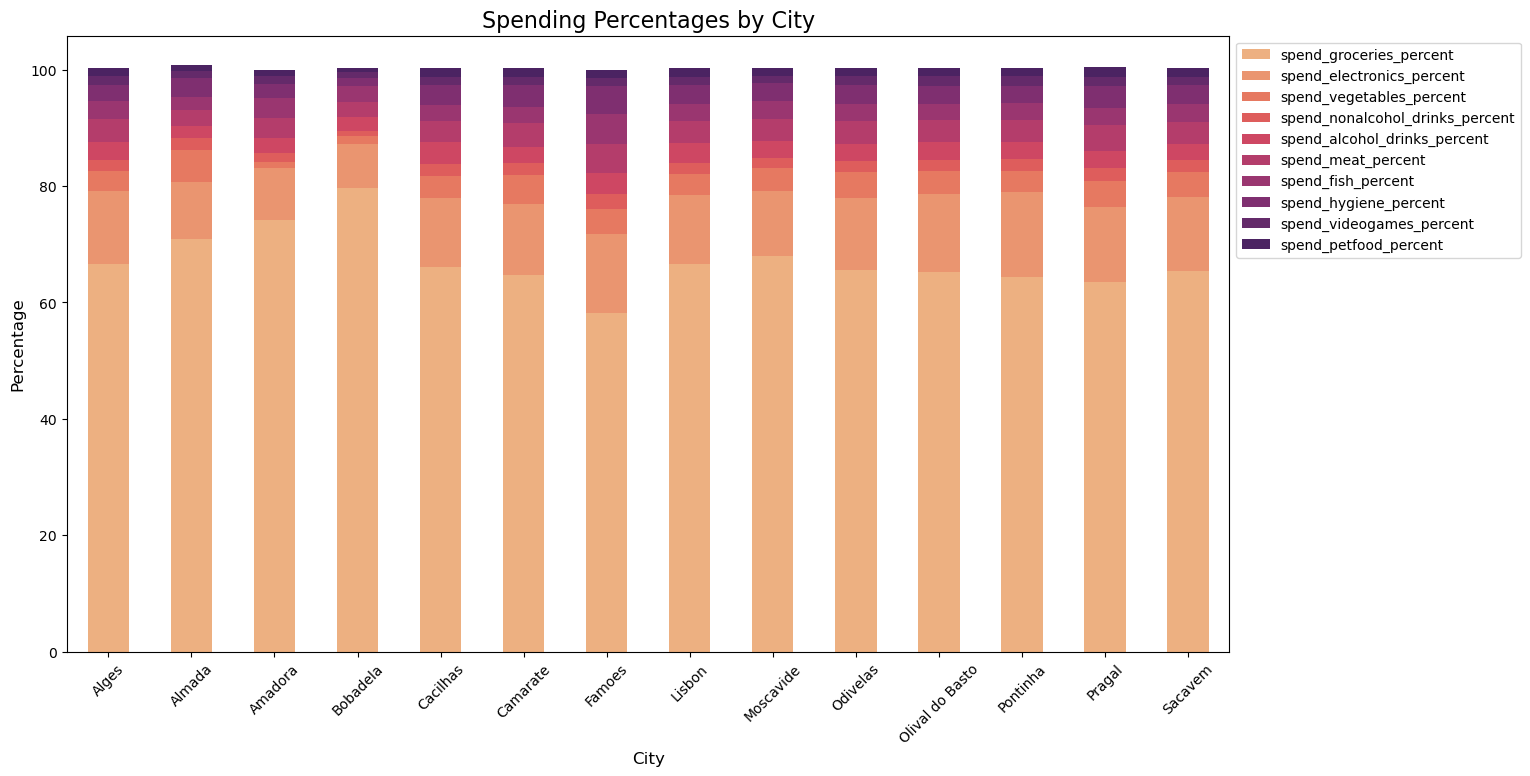

In [153]:
# Get columns with lifetime spend data
spending_percent_columns = [
    'spend_groceries_percent', 'spend_electronics_percent', 'spend_vegetables_percent',
    'spend_nonalcohol_drinks_percent', 'spend_alcohol_drinks_percent', 'spend_meat_percent',
    'spend_fish_percent', 'spend_hygiene_percent', 'spend_videogames_percent', 'spend_petfood_percent']

# Calculate the mean spending percentages by city
city_spending = info_df.groupby('city')[spending_percent_columns].mean()

# Plot the spending percentages by city
city_spending.plot(kind='bar', stacked=True, figsize=(15, 8), colormap='flare')
plt.title('Spending Percentages by City', fontsize=16)
plt.xlabel('City', fontsize=12)
plt.ylabel('Percentage', fontsize=12)
plt.xticks(rotation=45)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

## Correlations visualization

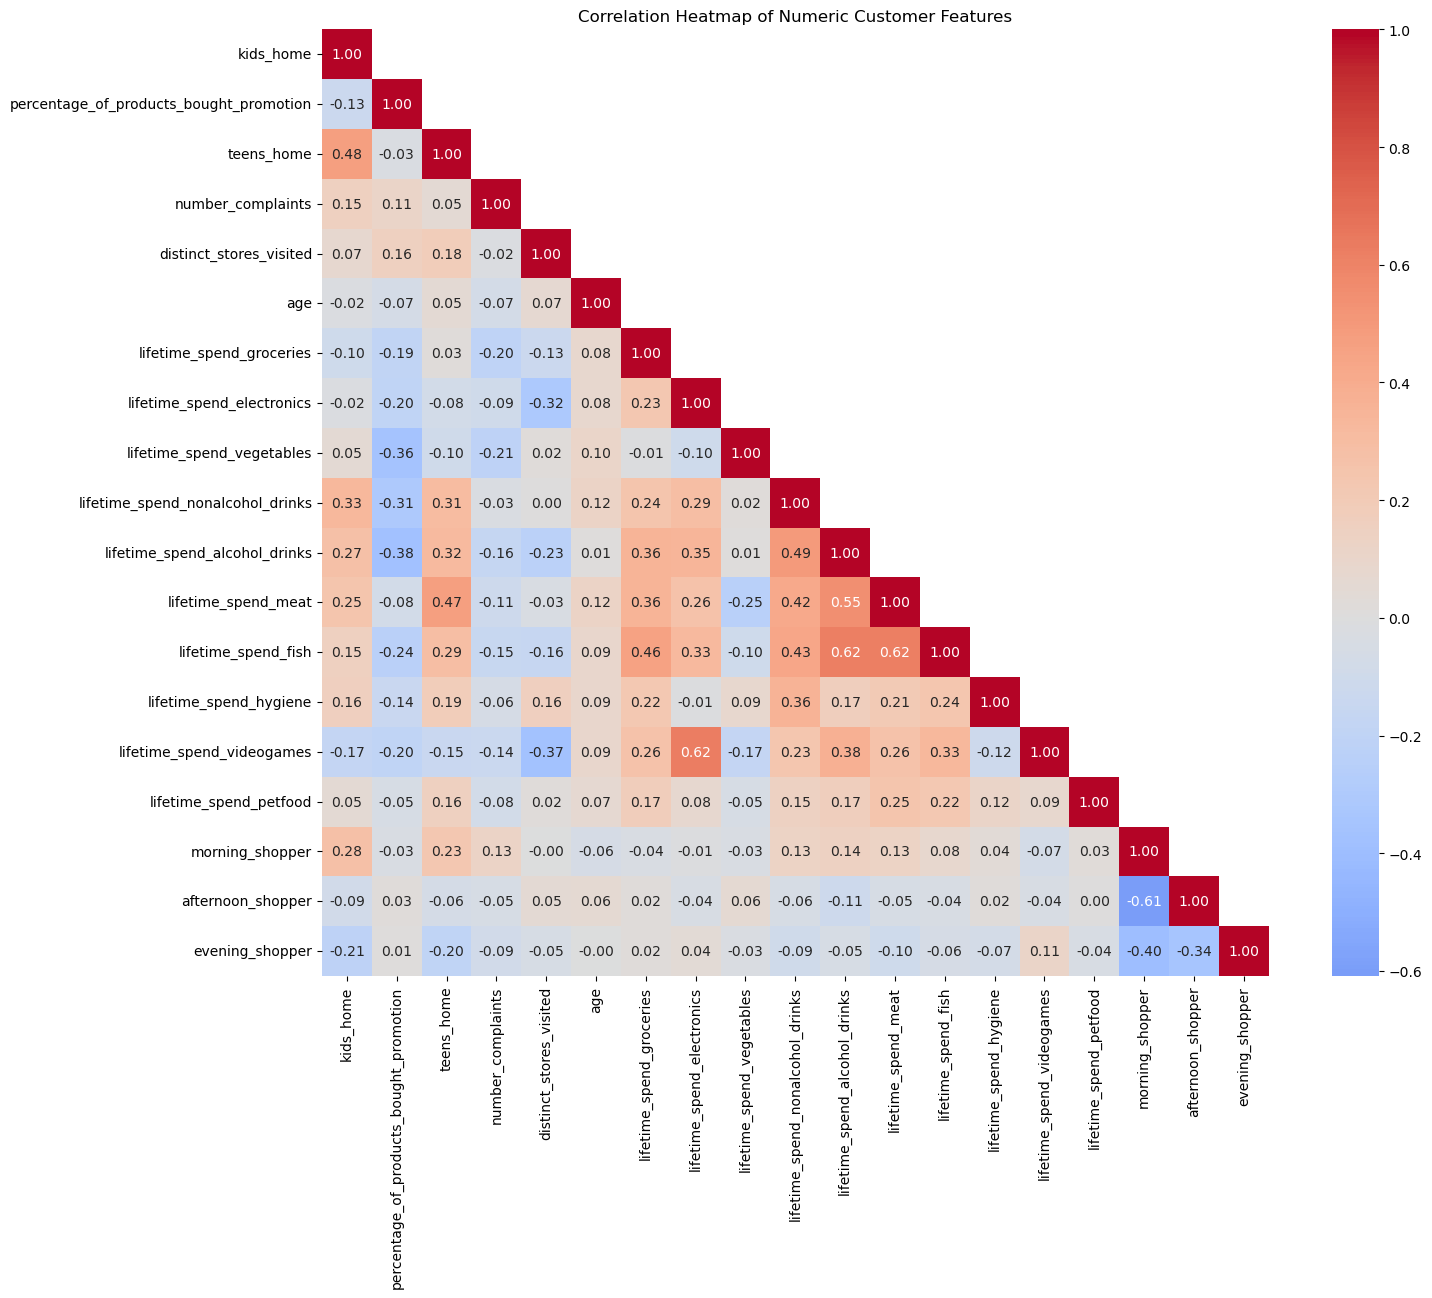

In [154]:
# Define the columns to plot
columns = ['kids_home', 'percentage_of_products_bought_promotion', 'teens_home', 'number_complaints', 
                   'distinct_stores_visited', 'age', 'lifetime_spend_groceries', 'lifetime_spend_electronics', 
                   'lifetime_spend_vegetables', 'lifetime_spend_nonalcohol_drinks', 'lifetime_spend_alcohol_drinks', 
                   'lifetime_spend_meat', 'lifetime_spend_fish', 'lifetime_spend_hygiene', 'lifetime_spend_videogames', 
                   'lifetime_spend_petfood', 'morning_shopper', 'afternoon_shopper', 'evening_shopper']

# Calculate the correlation matrix for the selected columns
correlation_matrix = info_df[columns].corr()

# Create a mask to remove duplicate correlations but keep the diagonal
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool), k=1)

# Plot the heatmap
plt.figure(figsize=(16, 13))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f', mask=mask, square=True)
plt.title('Correlation Heatmap of Numeric Customer Features')
plt.tight_layout()
plt.show()

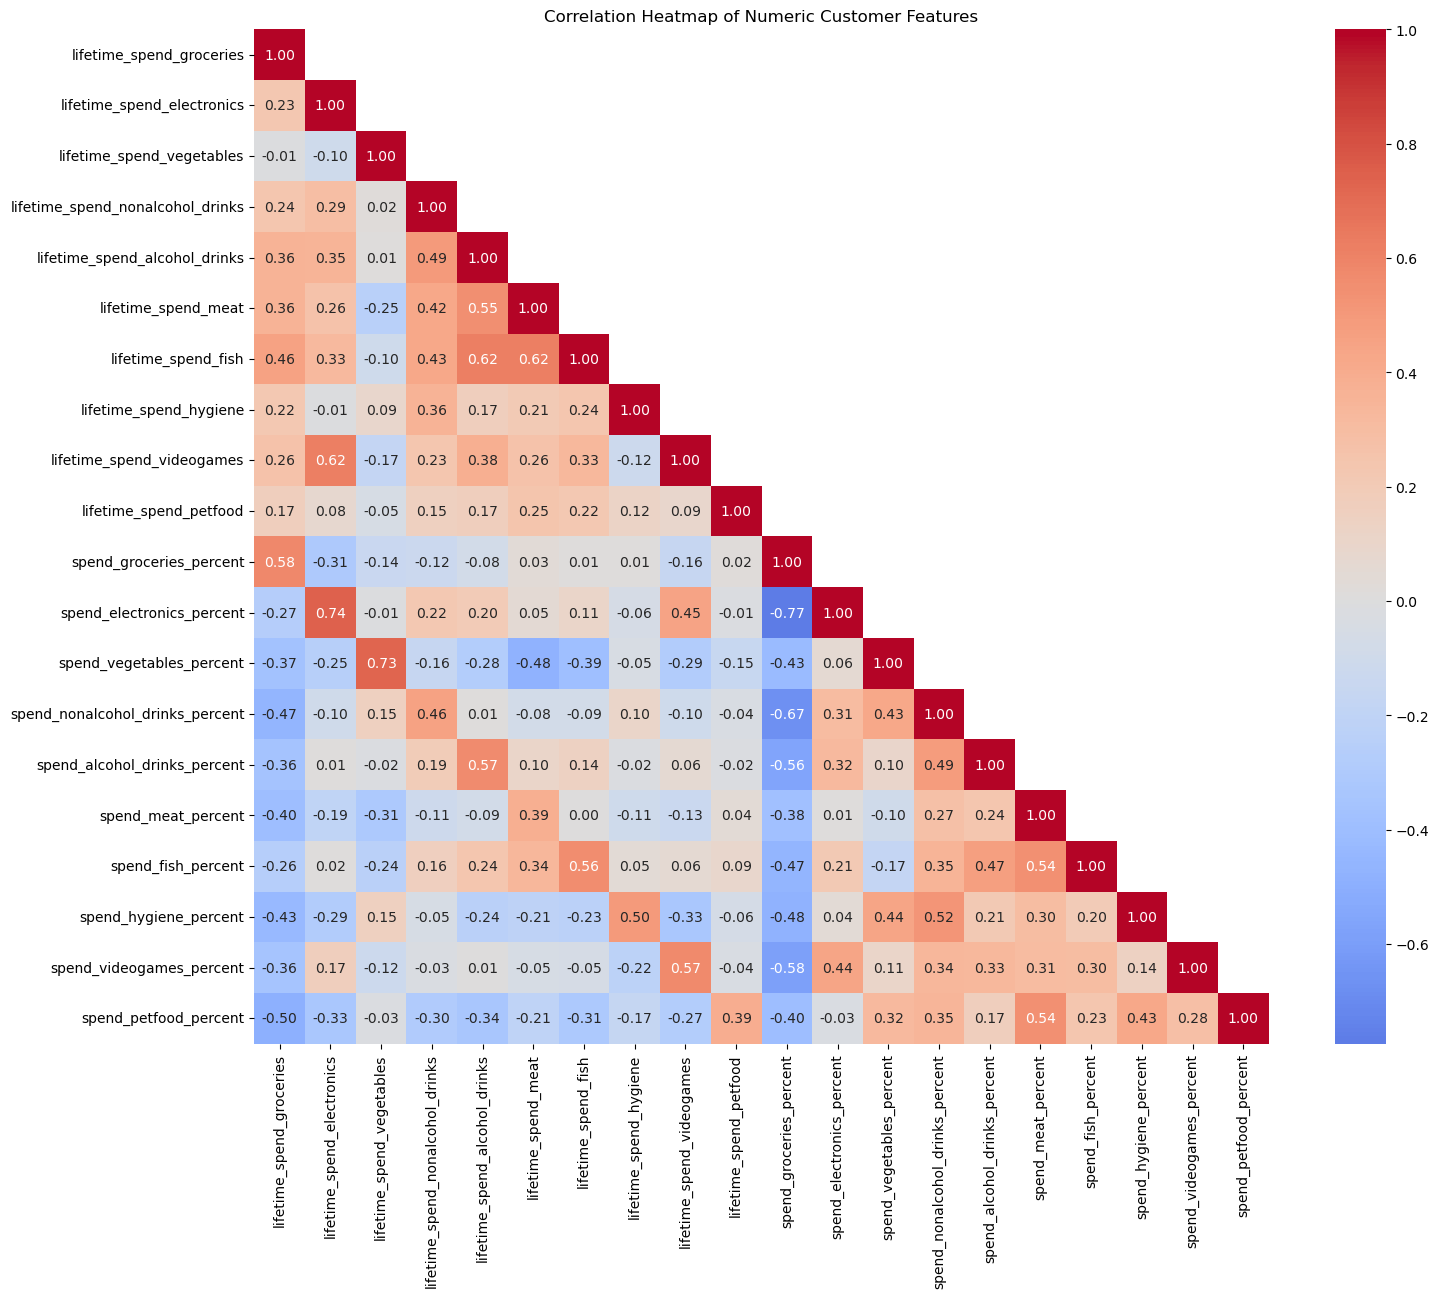

In [155]:
# Cheaking the correlation between lifetime spend and percentage spend
# Define the columns to plot
columns = ['lifetime_spend_groceries',
       'lifetime_spend_electronics', 'lifetime_spend_vegetables',
       'lifetime_spend_nonalcohol_drinks', 'lifetime_spend_alcohol_drinks',
       'lifetime_spend_meat', 'lifetime_spend_fish', 'lifetime_spend_hygiene',
       'lifetime_spend_videogames', 'lifetime_spend_petfood', 
       'spend_groceries_percent',
       'spend_electronics_percent', 'spend_vegetables_percent',
       'spend_nonalcohol_drinks_percent', 'spend_alcohol_drinks_percent',
       'spend_meat_percent', 'spend_fish_percent', 'spend_hygiene_percent',
       'spend_videogames_percent', 'spend_petfood_percent']

# Calculate the correlation matrix for the selected columns
correlation_matrix = info_df[columns].corr()

# Create a mask to remove duplicate correlations but keep the diagonal
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool), k=1)

# Plot the heatmap
plt.figure(figsize=(16, 13))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f', mask=mask, square=True)
plt.title('Correlation Heatmap of Numeric Customer Features')
plt.tight_layout()
plt.show()

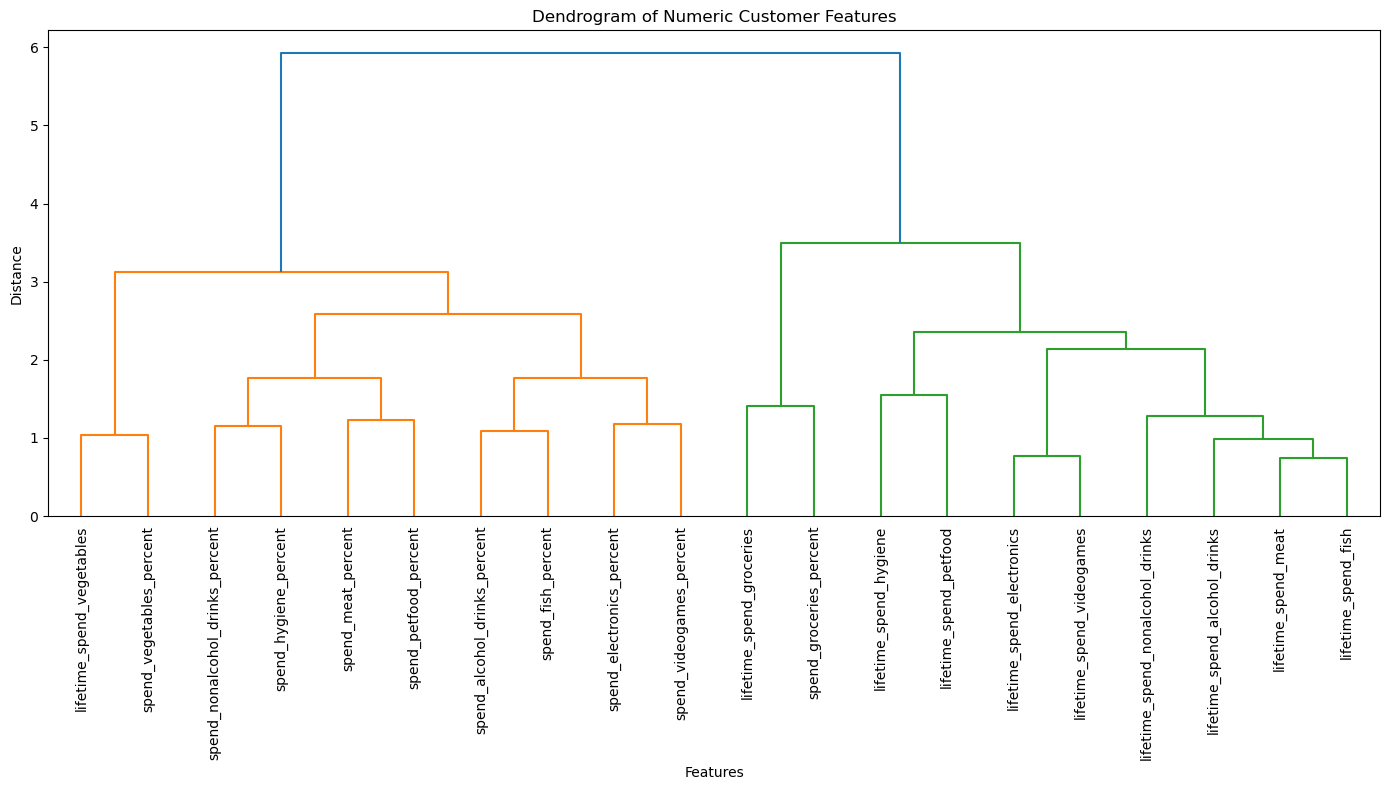

In [156]:
# Convert the correlation matrix to a distance matrix
distance_matrix = 1 - correlation_matrix

# Perform hierarchical clustering
linkage_matrix = sch.linkage(distance_matrix, method='ward')

# Plot the dendrogram
plt.figure(figsize=(14, 8))
dendrogram = sch.dendrogram(linkage_matrix, labels=columns, leaf_rotation=90, leaf_font_size=10)
plt.title('Dendrogram of Numeric Customer Features')
plt.xlabel('Features')
plt.ylabel('Distance')
plt.tight_layout()
plt.show()

## Basket visualization

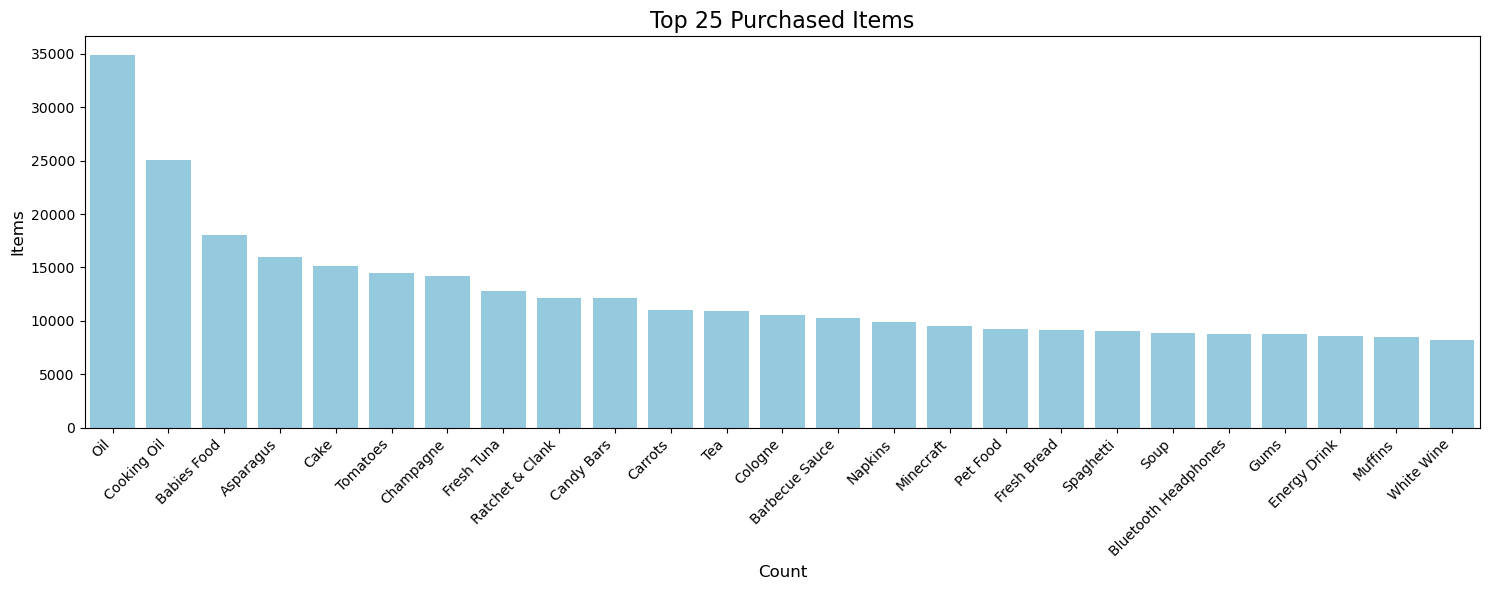

In [157]:
# Count the occurrences of each item
item_counts = Counter([item for sublist in all_items['all_purchased_items'] for item in sublist])

# Get the top most common items
top_items = item_counts.most_common(25)

# Separate the items and their counts for plotting
items, counts = zip(*top_items)
items = [item.replace('_', ' ').title() for item in items]  # Format item names
counts = list(counts)

# Plot the top items
plt.figure(figsize=(15, 6))
sns.barplot(x=items, y=counts, color='skyblue')
plt.title(f'Top {len(items)} Purchased Items', fontsize=16)
plt.xlabel('Count', fontsize=12)
plt.ylabel('Items', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Clustering

## Scaling the data

In [158]:
# Create a new DataFrame with imputed and scaled features
info_df_scaled = imputation_scaling(info_df)

# Check the shape of the scaled DataFrame
info_df_scaled.shape

(34060, 56)

## DBScan

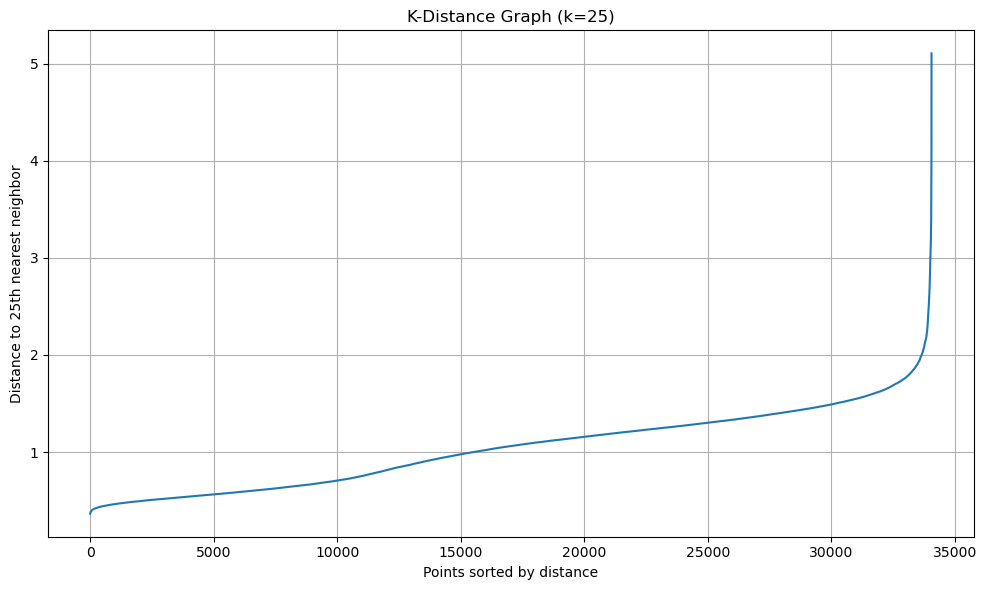

In [159]:
# Plot the k-distance graph to find the DBSCAN epsilon parameter
k_distance_graph(info_df_scaled, k=25)

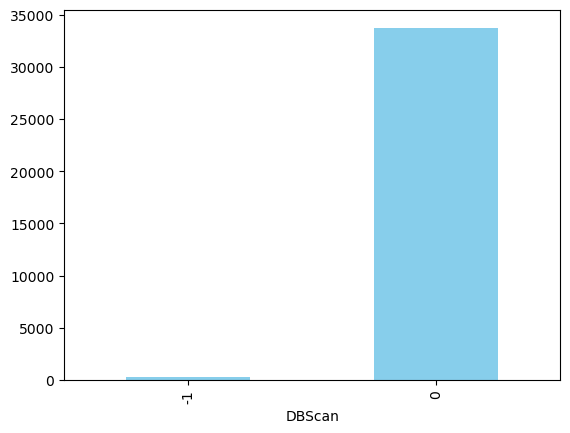

DBScan
-1      325
 0    33735
dtype: int64


(33735, 56)

In [160]:
# We are going to use a higher value of eps to get the outliers
# And then remove them from the main dataset
# For extra safety, we will keep the outliers in a separate DataFrame
info_df_scaled, outliers_df = remove_outliers(info_df_scaled, 1.65, min_samples=25)

# Check the shape of the scaled DataFrame after removing outliers
info_df_scaled.shape

## K-mean

In [161]:
# Reduce the dimensionality of the dataset by dropping some features
dimensionality_reduction(info_df_scaled)

# Check the shape of the scaled DataFrame after dimensionality reduction
info_df_scaled.shape

(33735, 21)

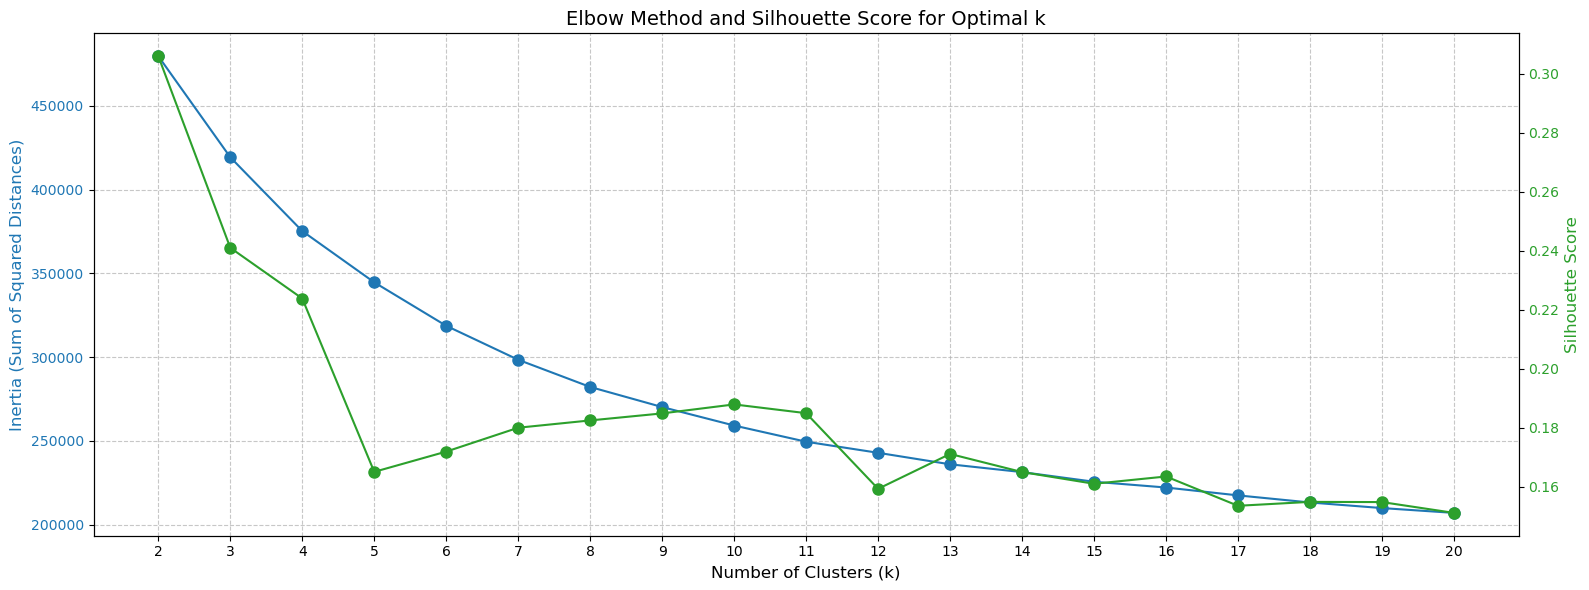

In [162]:
# Plot the inertia and silhouette scores for different values of k
elbow_and_silhouette(info_df_scaled, max_k=21)

In [163]:
# Using the graph above, cluster the data with k=6
info_df_clustered, cluster_profiles = kmeans_clustering(info_df_scaled, 10)

# Cheak the custer profiles
cluster_profiles

kids_home  teens_home  number_complaints  distinct_stores_visited  \
cluster                                                                      
0            -0.01       -0.69              -0.28                     0.08   
1             0.59       -0.16               0.78                    -0.48   
2            -0.34       -0.20              -0.42                    -0.21   
3             3.33        1.00              -0.14                     0.07   
4            -0.01       -0.65              -0.28                     0.10   
5             0.06        0.43              -0.18                     0.18   
6            -0.49       -0.05              -0.26                     0.49   
7            -0.48       -0.02              -0.28                     0.49   
8             0.50        0.32              -0.07                     0.07   
9            -0.72       -0.72              -0.11                    -0.78   

         lifetime_total_distinct_products  \
cluster                                     
0                                   -0.24   
1                                   -0.34   
2                                    0.38   
3                                    1.04   
4                                   -0.25   
5                                    0.79   
6                                   -0.38   
7                                   -0.39   
8                                    0.66   
9                                    0.01   

         percentage_of_products_bought_promotion   age  total_lifetime_spend  \
cluster                                                                        
0                                          -0.34  0.06                 -0.24   
1                                           0.59 -0.61                 -0.35   
2                                           0.06  0.08                  1.32   
3                                          -0.10  0.10                  0.31   
4                                          -0.33  0.09                 -0.60   
5                                           0.06  0.08                  0.20   
6                                           1.17  0.06                 -0.69   
7                                           1.17  0.08                 -0.38   
8                                           0.07  0.11                 -0.39   
9                                           0.16  0.03                  0.17   

         spend_groceries_percent  spend_electronics_percent  \
cluster                                                       
0                          -0.22                       0.12   
1                           0.13                      -0.24   
2                           0.48                      -0.10   
3                          -0.44                       0.46   
4                          -1.87                       0.88   
5                          -0.31                       0.32   
6                          -1.28                      -0.22   
7                           0.30                      -0.53   
8                          -2.03                       1.27   
9                          -1.10                       1.91   

         spend_vegetables_percent  spend_nonalcohol_drinks_percent  \
cluster                                                              
0                            2.94                             0.44   
1                           -0.11                            -0.02   
2                           -0.21                            -0.41   
3                            0.24                             0.60   
4                            6.89                             2.10   
5                            0.09                             0.56   
6                            1.81                             0.78   
7                            0.47                            -0.30   
8                            0.73                             2.32   
9                           -0.24          

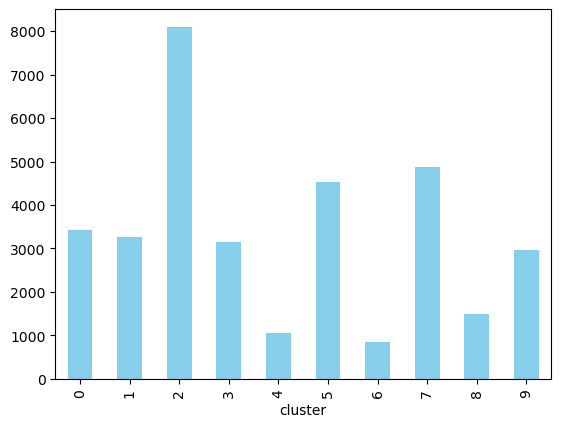

In [164]:
# Cheak the number of customers in each cluster
info_df_clustered.groupby(['cluster']).size().plot(kind='bar', color='skyblue')
plt.show()

In [165]:
# Generate cluster names (most significant features)
cluster_names = generate_cluster_names(cluster_profiles, z_threshold=0.5)

# Print cluster descriptions
for k, v in cluster_names.items():
    print(f"Cluster {k}: {v}")

Cluster 0: HIGH : spend vegetables percent | LOW : spend meat percent, spend fish percent, teens home, percentage of products bought promotion
Cluster 1: HIGH : spend alcohol drinks percent, degree level None | LOW : age, distinct stores visited, total lifetime spend, lifetime total distinct products
Cluster 2: HIGH : total lifetime spend | LOW : number complaints, spend nonalcohol drinks percent, spend petfood percent, kids home
Cluster 3: HIGH : kids home, lifetime total distinct products, teens home, spend alcohol drinks percent | LOW : spend groceries percent
Cluster 4: HIGH : spend vegetables percent, spend hygiene percent, spend nonalcohol drinks percent, spend petfood percent | LOW : spend groceries percent, spend meat percent, teens home, spend fish percent
Cluster 5: No significant high features | LOW : spend groceries percent, number complaints
Cluster 6: HIGH : spend petfood percent, spend meat percent, spend videogames percent, spend vegetables percent | LOW : spend groceri

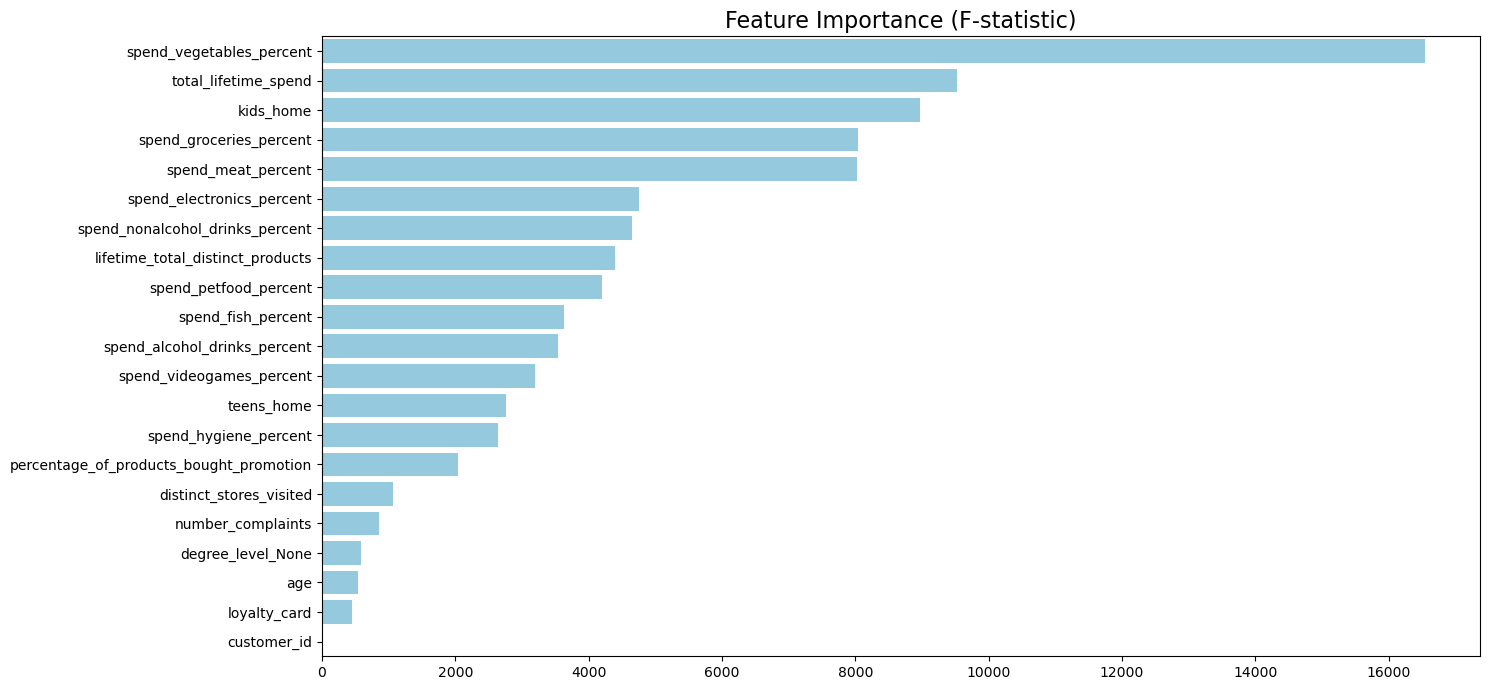

In [166]:
# Calculate and plot feature importance based on F-statistic
calculate_f_statistic_importance(info_df_clustered)

## UMAP

In [167]:
info_df_clustered


customer_id  kids_home  teens_home  number_complaints  \
0            29930        1.0         1.0                0.0   
1             6813       -1.0         0.0               -1.0   
2            39451        1.0         2.0               -1.0   
3            21557       -1.0        -1.0                0.0   
4            16415        0.0         0.0                0.0   
...            ...        ...         ...                ...   
33730        37071        0.0         0.0               -1.0   
33731        27422        0.0         0.0               -1.0   
33732        39540        0.0        -1.0                0.0   
33733        18367        0.0         0.0                0.0   
33734        22050        1.0         0.0                1.0   

       distinct_stores_visited  lifetime_total_distinct_products  \
0                          0.5                          1.526012   
1                          0.5                         -0.283237   
2                          2.0                          1.138728   
3                         -1.0                          0.572254   
4                          1.0                          0.705202   
...                        ...                               ...   
33730                     -0.5                          0.236994   
33731                      0.0                          1.485549   
33732                     -0.5                          0.612717   
33733                      0.5                          0.167630   
33734                     -1.0                         -0.213873   

       percentage_of_products_bought_promotion       age  \
0                                    -0.203400 -0.032258   
1                                     2.460565  0.870968   
2                                    -0.345781 -0.580645   
3                                     0.048761 -0.161290   
4                                     0.192977  0.161290   
...                                        ...       ...   
33730                                -0.194453 -0.903226   
33731                                 0.931401 -0.419355   
33732                                 0.735651 -0.935484   
33733                                 0.484980  0.322581   
33734                                 0.734382 -0.709677   

       total_lifetime_spend  spend_groceries_percent  ...  \
0                 -0.152291                -1.559857  ...   
1                 -0.501234                 0.239954  ...   
2                  0.137334                -0.776747  ...   
3                  0.344696                -1.480192  ...   
4                  1.179119                 0.699005  ...   
...                     ...                      ...  ...   
33730              1.786829                 0.623465  ...   
33731             -0.005518                -0.294441  ...   
33732              0.092609                -0.829223  ...   
33733              0.781493                 0.450321  ...   
33734             -0.506752                 0.103510  ...   

       spend_nonalcohol_drinks_percent  spend_alcohol_drinks_percent  \
0                             1.979637                      1.215419   
1                            -0.466082                     -0.597006   
2                             1.186837                      1.472666   
3                            -0.543150                      1.058678   
4                            -0.221385                     -0.581963   
...                                ...                           ...   
33730                        -0.586340                     -0.171174   
33731                         0.923759                      0.096773   
33732                        -0.431379                     -0.285734   
33733                        -0.368331                      0.237665   
33734                        -0.805194                      1.879045   

       spend_meat_percent  spend_fish_percent  spend_hygiene_percent  \
0                1.331340     

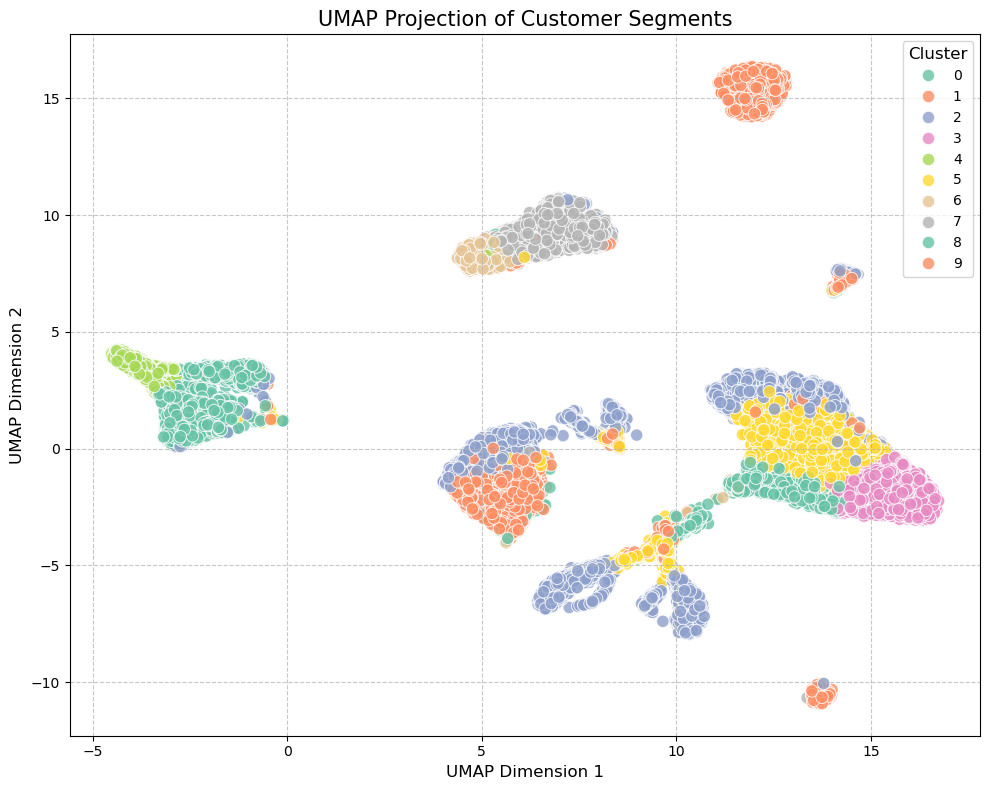

In [168]:
import matplotlib.pyplot as plt
import seaborn as sns
from umap import UMAP
import numpy as np

# Set a random seed for reproducibility
random_state = 42

# Apply UMAP for dimensionality reduction
umap_model = UMAP(n_components=2, random_state=random_state)
umap_result = umap_model.fit_transform(info_df_clustered.drop(columns=['cluster', 'customer_id'] , axis=1))
info_df_clustered['umap1'] = umap_result[:, 0]
info_df_clustered['umap2'] = umap_result[:, 1]

# Create the visualization
plt.figure(figsize=(10, 8))
scatter = sns.scatterplot(
    data=info_df_clustered, 
    x='umap1', 
    y='umap2', 
    hue='cluster', 
    palette='Set2',
    alpha=0.8,
    s=80
)

# Add title and labels
plt.title('UMAP Projection of Customer Segments', fontsize=15)
plt.xlabel('UMAP Dimension 1', fontsize=12)
plt.ylabel('UMAP Dimension 2', fontsize=12)

# Improve legend
plt.legend(title='Cluster', title_fontsize=12, fontsize=10)

# Add a grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Tight layout
plt.tight_layout()
 
# Show the plot
plt.show()

## PCA

In [269]:
info_df_clustered.head()

customer_id  number_complaints  distinct_stores_visited  \
0        29930                0.0                      0.5   
1         6813               -1.0                      0.5   
2        39451               -1.0                      2.0   
3        21557                0.0                     -1.0   
4        16415                0.0                      1.0   

   lifetime_total_distinct_products  percentage_of_products_bought_promotion  \
0                          1.526012                                -0.203400   
1                         -0.283237                                 2.460565   
2                          1.138728                                -0.345781   
3                          0.572254                                 0.048761   
4                          0.705202                                 0.192977   

   year_first_transaction       age  total_lifetime_spend  \
0                0.428571 -0.032258             -0.152291   
1               -0.285714  0.870968             -0.501234   
2               -0.571429 -0.580645              0.137334   
3               -0.857143 -0.161290              0.344696   
4               -0.428571  0.161290              1.179119   

   spend_groceries_percent  spend_electronics_percent  ...  \
0                -1.559857                   1.314683  ...   
1                 0.239954                  -0.757044  ...   
2                -0.776747                   0.379330  ...   
3                -1.480192                   2.931608  ...   
4                 0.699005                  -0.344493  ...   

   spend_alcohol_drinks_percent  spend_meat_percent  spend_fish_percent  \
0                      1.215419            1.331340            2.540418   
1                     -0.597006            0.998795            0.181678   
2                      1.472666            0.431723            1.670145   
3                      1.058678           -0.118670           -0.118474   
4                     -0.581963           -0.415380            0.010232   

   spend_hygiene_percent  spend_videogames_percent  spend_petfood_percent  \
0              -0.092690                  0.700928               0.701669   
1               0.348051                 -0.433770               0.655166   
2               0.254333                  0.001513              -0.365899   
3              -0.707418                  0.699509              -0.275649   
4              -0.216748                 -0.835197              -0.686586   

   loyalty_card  total_children  degree_level_None  cluster  
0             0             1.0                1.0        1  
1             1            -0.5                0.0        4  
2             0             1.5                1.0        1  
3             0            -1.0                1.0        0  
4             1             0.0                0.0        3  

[5 rows x 22 columns]

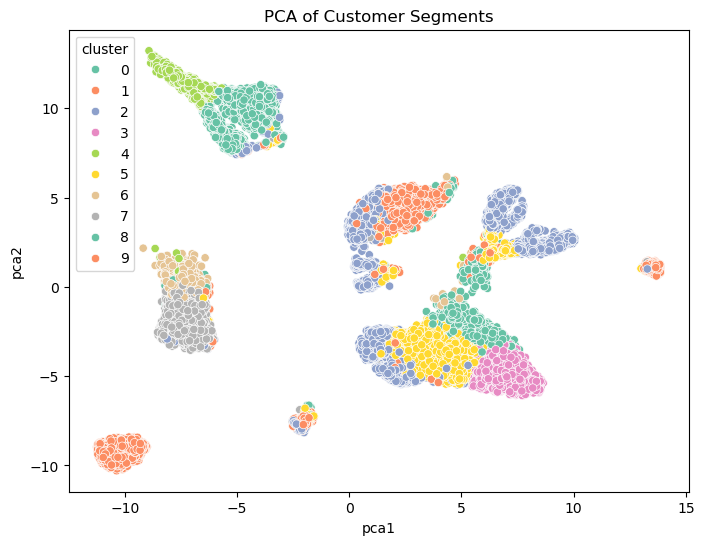

Variance explained by each component: [0.46445977 0.36806779]
Total variance explained: 83.25%


In [169]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
pca_result = pca.fit_transform(info_df_clustered.drop(columns=['cluster', 'customer_id'], axis=1))
info_df_clustered['pca1'] = pca_result[:, 0]
info_df_clustered['pca2'] = pca_result[:, 1]

plt.figure(figsize=(8, 6))
sns.scatterplot(data=info_df_clustered, x='pca1', y='pca2', hue='cluster', palette='Set2')
plt.title('PCA of Customer Segments')
plt.show()

# Get explained variance ratio
explained_variance = pca.explained_variance_ratio_
print(f"Variance explained by each component: {explained_variance}")
print(f"Total variance explained: {sum(explained_variance):.2%}")

## SOM (unused)

In [271]:
# Initialize SOM
som = MiniSom(x=15, y=15, 
              input_len=info_df_scaled.shape[1],  # Number of features
              sigma=1.5,                          # Initial neighborhood radius
              learning_rate=0.3,                  # Initial learning rate
              neighborhood_function='gaussian',
              random_seed=42)

In [272]:
# # Convert DataFrame to NumPy array before passing to SOM
# info_df_scaled_array = np.array(info_df_scaled)

# # Set the seed for reproducibility
# np.random.seed(42)

# num_iterations = 500
# q_errors = []

# # Train the SOM with single update and track error
# for i in range(num_iterations):

#     # Usually you would calculate these based on the iteration number
#     current_lr = 0.5 * (1 - i/num_iterations)  # Linear decay from 0.5 to 0
    
#     # Train for a single iteration (all samples once)
#     som.train_batch(info_df_scaled_array, num_iteration=1)
    
#     # Calculate and store quantization error
#     q_errors.append(som.quantization_error(info_df_scaled_array))
    
#     if i % 100 == 0:
#         print(f"Iteration {i}, Quantization error: {q_errors[-1]}")

# # Plot the quantization error over iterations
# plt.figure(figsize=(10, 6))
# plt.plot(q_errors)
# plt.title('Quantization Error vs. Iteration')
# plt.xlabel('Iteration')
# plt.ylabel('Quantization Error')
# plt.grid(True)
# plt.show()